# Data Preprocessing v2

## Imports

Auto update from code base

In [1]:
%load_ext autoreload
%autoreload 2

Import libraries

In [33]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2, glob, os, pickle, skimage

Import labels

In [3]:
labels_df = pd.read_csv('data/raw/train.csv', dtype={'Id': 'str'})
print(labels_df.head())
print(labels_df.shape)

           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale
(25361, 2)


Number and distribution of classes

In [5]:
classes_unique = list(set(labels_df['Id']))
print('No of classes:', len(classes_unique))
class_count_list = [labels_df[labels_df['Id'] == class_id].shape[0]\
                    for class_id in classes_unique]

No of classes: 5005


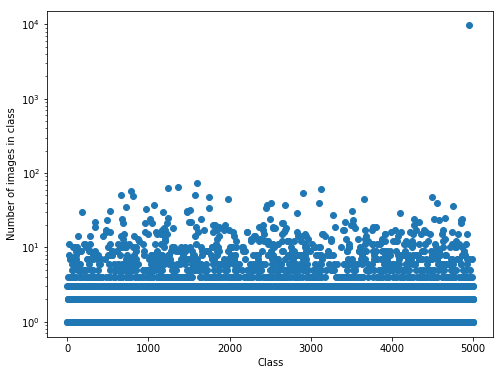

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(classes_unique))), class_count_list)
plt.xlabel('Class')
plt.ylabel('Number of images in class')
plt.yscale('log')
plt.show()
plt.savefig('class_distribution.png')

## Explore and preprocess images

Image with more sea water than whale fluke

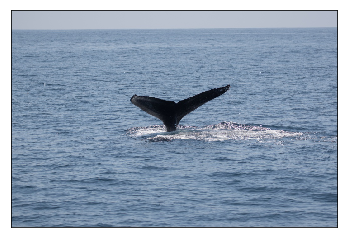

In [21]:
image = skimage.io.imread('data/raw/train/30c77baaa.jpg')
plt.imshow(image)
plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.savefig('image_more_sea_water.png')

Image with words

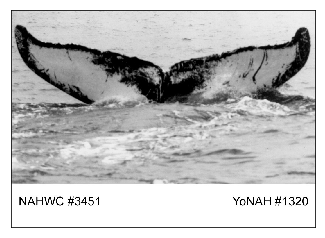

In [23]:
image = skimage.io.imread('data/raw/train/2b96cac5a.jpg')
# Convert image from grayscale to RGB
image = skimage.color.gray2rgb(image)
plt.imshow(image)
plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.savefig('image_words.png')

Import vertices of bounding box boundaries. Bounding box vertices done in [this Kaggle kernel](https://www.kaggle.com/suicaokhoailang/generating-whale-bounding-boxes)

In [11]:
bbox_df = pd.read_csv('bounding_boxes.csv')

Import several train images, and draw bounding boxes

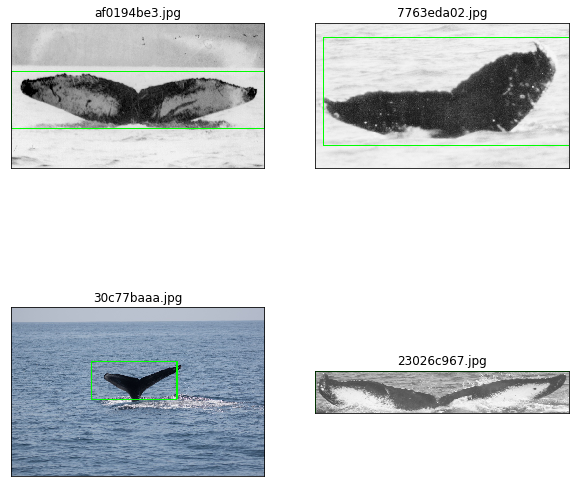

In [25]:
plt.figure(figsize=(10, 10))
train_file_list_partial = glob.glob('data/raw/train/*.jpg')[:4]
train_file_list_short_partial = [train_file.replace('data/raw/train/', '') for train_file in train_file_list_partial]

for i in range(4):
    plt.subplot(2, 2, i + 1)
    image = skimage.io.imread(train_file_list_partial[i])
    image_rgb = skimage.color.gray2rgb(image)
    x0, y0, x1, y1 = np.array(bbox_df[bbox_df.Image ==\
                                      train_file_list_short_partial[i]][['x0', 'y0', 'x1', 'y1']]).flatten()
    # Adding crop margin to compensate for inaccuracies in bounding box
    crop_margin = 0.05
    # Using max and min to prevent adjusted bounding box vertices from going beyond the image boundary
    x0, y0 = max(0, int((1 - crop_margin) * x0)), max(0, int((1 - crop_margin) * y0))
    x1, y1 = min(image.shape[1], int((1 + crop_margin) * x1)), min(image.shape[0], int((1 + crop_margin) * y1))
    cv2.rectangle(image_rgb,(x0,y0),(x1,y1),(0,255,0),3)
    plt.title(train_file_list_short_partial[i])
    plt.imshow(image_rgb)
    plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.savefig('image_bounding_box_{}.png'.format(i + 1))

Import several test images, and draw bounding boxes

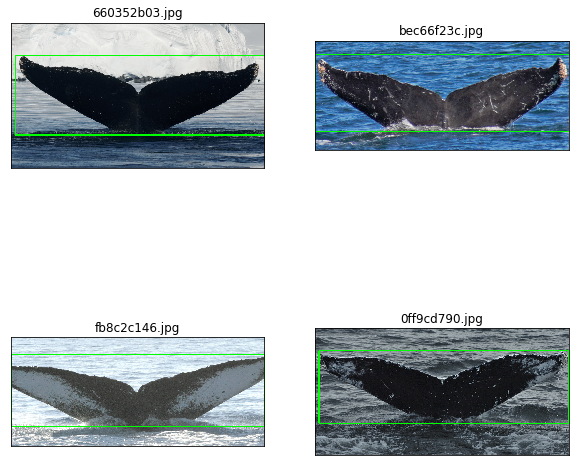

In [26]:
plt.figure(figsize=(10, 10))
test_file_list_partial = glob.glob('data/raw/test/*.jpg')[:4]
test_file_list_short_partial = [test_file.replace('data/raw/test/', '') for test_file in test_file_list_partial]

for i in range(4):
    plt.subplot(2, 2, i + 1)
    image = skimage.io.imread(test_file_list_partial[i])
    image_rgb = skimage.color.gray2rgb(image)
    x0, y0, x1, y1 = np.array(bbox_df[bbox_df.Image ==\
                                      test_file_list_short_partial[i]][['x0', 'y0', 'x1', 'y1']]).flatten()
    # Adding crop margin to compensate for inaccuracies in bounding box
    crop_margin = 0.05
    # Using max and min to prevent adjusted bounding box vertices from going beyond the image boundary
    x0, y0 = max(0, int((1 - crop_margin) * x0)), max(0, int((1 - crop_margin) * y0))
    x1, y1 = min(image.shape[1], int((1 + crop_margin) * x1)), min(image.shape[0], int((1 + crop_margin) * y1))
    cv2.rectangle(image_rgb,(x0,y0),(x1,y1),(0,255,0),3)
    plt.title(test_file_list_short_partial[i])
    plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.imshow(image_rgb)

Crop one training image

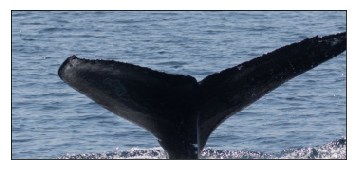

In [30]:
image = skimage.io.imread('data/raw/train/30c77baaa.jpg')
x0, y0, x1, y1 = np.array(bbox_df[bbox_df.Image == '30c77baaa.jpg'][['x0', 'y0', 'x1', 'y1']]).flatten()
x0, y0 = max(0, int((1 - crop_margin) * x0)), max(0, int((1 - crop_margin) * y0))
x1, y1 = min(image.shape[1], int((1 + crop_margin) * x1)), min(image.shape[0], int((1 + crop_margin) * y1))
image_cropped = image[y0:y1, x0:x1]
plt.imshow(image_cropped)
plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)

Resize above image

Resized image shape: (224, 224, 3)


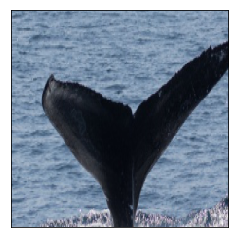

In [29]:
resize_width = 224
image = skimage.io.imread('data/raw/train/30c77baaa.jpg')
x0, y0, x1, y1 = np.array(bbox_df[bbox_df.Image == '30c77baaa.jpg'][['x0', 'y0', 'x1', 'y1']]).flatten()
x0, y0 = max(0, int((1 - crop_margin) * x0)), max(0, int((1 - crop_margin) * y0))
x1, y1 = min(image.shape[1], int((1 + crop_margin) * x1)), min(image.shape[0], int((1 + crop_margin) * y1))
image_cropped = image[y0:y1, x0:x1]
image_resized = cv2.resize(image_cropped, (resize_width, resize_width), interpolation=cv2.INTER_AREA)
plt.imshow(image_resized)
plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
print('Resized image shape:', image_resized.shape)

Import training set images and convert to NumPy arrays

In [35]:
train_file_list_original = glob.glob('data/raw/train/*.jpg')
train_file_list_short = [train_file.replace('data/raw/train/', '')\
                         for train_file in train_file_list_original]
print(train_file_list_short[:5])
print(train_file_list_original[:5])
print(len(train_file_list_short))
print(len(train_file_list_original))

['af0194be3.jpg', '7763eda02.jpg', '30c77baaa.jpg', '23026c967.jpg', '41a0660cb.jpg']
['data/raw/train/af0194be3.jpg', 'data/raw/train/7763eda02.jpg', 'data/raw/train/30c77baaa.jpg', 'data/raw/train/23026c967.jpg', 'data/raw/train/41a0660cb.jpg']
25361
25361


In [36]:
data_train_output_path = 'data/derived/preprocessed_train/'
labels_train_pickle_path = 'data/derived/labels_train.pickle'

for filename, fullpath in zip(train_file_list_short, train_file_list_original):
    fullpath_new = data_train_output_path + filename
    try:
        image = skimage.io.imread(fullpath)
        image_rgb = skimage.color.gray2rgb(image)
        x0, y0, x1, y1 = np.array(bbox_df[bbox_df.Image == filename][['x0', 'y0', 'x1', 'y1']]).flatten()
        image_cropped = image_rgb[y0:y1, x0:x1]
        skimage.io.imsave(fname=fullpath_new, arr=image_cropped)
    except:
        print('Image File {} could not be preprocessed'.format(filename))
        continue
        
if os.path.exists(labels_train_pickle_path):
    print('Path {} exists'.format(labels_train_pickle_path))
else:
    labels_train = [labels_df[labels_df['Image'] == train_file_short]['Id'].to_string(header=False, index=False)\
                   for train_file_short in train_file_list_short]
    with open(labels_train_pickle_path, 'wb') as file:
        pickle.dump(labels_train, file)

with open(labels_train_pickle_path, 'rb') as file:
    labels_train = pickle.load(file)

labels_train: ['new_whale', 'new_whale', 'w_75d0e61', 'w_396c12b', 'w_d8de44c']
Training labels length: 25361


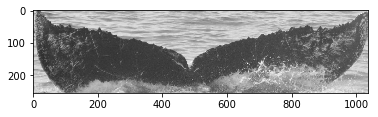

In [37]:
image = skimage.io.imread(data_train_output_path + 'fe896a2be.jpg')
plt.imshow(image)
  
print('labels_train:', labels_train[:5])
print('Training labels length:', len(labels_train))

In [39]:
test_file_list_original = glob.glob('data/raw/test/*.jpg')
test_file_list_short = [test_file.replace('data/raw/test/', '')\
                         for test_file in test_file_list_original]
if os.path.exists('data/derived/test_file_names.pickle'):
    print('Path {} exists'.format('data/derived/test_file_names.pickle'))
else:
    with open('data/derived/test_file_names.pickle', 'wb') as file:
        pickle.dump(test_file_list_short, file)

print(test_file_list_original[:5])
print(test_file_list_short[:5])
print(len(test_file_list_original))
print(len(test_file_list_short))

['data/raw/test/660352b03.jpg', 'data/raw/test/bec66f23c.jpg', 'data/raw/test/fb8c2c146.jpg', 'data/raw/test/0ff9cd790.jpg', 'data/raw/test/861e6c332.jpg']
['660352b03.jpg', 'bec66f23c.jpg', 'fb8c2c146.jpg', '0ff9cd790.jpg', '861e6c332.jpg']
7960
7960


In [40]:
data_test_output_path = 'data/derived/preprocessed_test/'

for filename, fullpath in zip(test_file_list_short, test_file_list_original):
    fullpath_new = data_test_output_path + filename
    try:
        image = skimage.io.imread(fullpath)
        image_rgb = skimage.color.gray2rgb(image)
        x0, y0, x1, y1 = np.array(bbox_df[bbox_df.Image == filename][['x0', 'y0', 'x1', 'y1']]).flatten()
        image_cropped = image_rgb[y0:y1, x0:x1]
        skimage.io.imsave(fname=fullpath_new, arr=image_cropped)
    except:
        print('Image File {} could not be preprocessed'.format(filename))
        continue

In [41]:
preprocessed_train_image_paths = glob.glob('data/derived/preprocessed_train/*')
preprocessed_test_image_paths = glob.glob('data/derived/preprocessed_test/*')
print('No of preprocessed training images:', len(preprocessed_train_image_paths))
print('No of preprocessed test images:', len(preprocessed_test_image_paths))

No of preprocessed training images: 25361
No of preprocessed test images: 7960


Text(0.5, 1.0, 'Horizontal Flip')

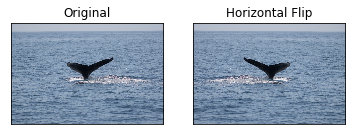

In [32]:
# Test horizontal flip
image = skimage.io.imread('data/raw/train/30c77baaa.jpg')
image_flipped = image[:, ::-1]
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(image_flipped)
plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.title('Horizontal Flip')